## Figure 3

- Panel A: Accuracy for all plates
- Panel B: PR curves for all plates
- Panel C: Confusion matrix for all plates

In [1]:
suppressPackageStartupMessages(library(dplyr))
suppressPackageStartupMessages(library(ggplot2))
suppressPackageStartupMessages(library(patchwork))
suppressPackageStartupMessages(library(arrow))
suppressPackageStartupMessages(library(RColorBrewer))

Warning message:
“package ‘dplyr’ was built under R version 4.2.3”
Warning message:
“package ‘ggplot2’ was built under R version 4.2.3”
Warning message:
“package ‘patchwork’ was built under R version 4.2.3”
Warning message:
“package ‘arrow’ was built under R version 4.2.3”
Warning message:
“package ‘RColorBrewer’ was built under R version 4.2.3”


## Set paths

In [2]:
figure_dir <- "../figures"
output_main_figure_3 <- file.path(
    figure_dir, "main_figure_3_model_eval.png"
)

## Load in PR curve data

In [3]:
# Results directory for original model evaluation
results_dir <- file.path(
    "../../2.evaluate_model/model_evaluation_data/"
)

# Load data (includes optimization in this file)
PR_results_file <- file.path(results_dir, "precision_recall_final_qc_model.parquet")

PR_results_df <- arrow::read_parquet(PR_results_file)

dim(PR_results_df)
head(PR_results_df)

[1] 32374618        4

precision,recall,plate,datasplit
<dbl>,<dbl>,<chr>,<chr>
0.5000000,1,all_plates,val
0.5000001,1,all_plates,val
0.5000001,1,all_plates,val
0.5000002,1,all_plates,val
0.5000002,1,all_plates,val
0.5000003,1,all_plates,val


### Update data frame to create new column for the data type (shuffled or final)

In [4]:
# Create new column for model using the datasplit prefix
PR_results_df <- PR_results_df %>%
  mutate(shuffled_type = ifelse(grepl("^shuffled_", datasplit), "TRUE", "FALSE"))

# Remove "shuffled_" prefix from datasplit column for plotting
PR_results_df <- PR_results_df %>%
  mutate(datasplit = sub("^shuffled_", "", datasplit))

# Rename "data splits for interpretation
PR_results_df <- PR_results_df %>%
  mutate(datasplit = recode(datasplit, "test" = "Test", "train" = "Train", "val" = "Val"))
  
dim(PR_results_df)
head(PR_results_df)

[1] 32374618        5

precision,recall,plate,datasplit,shuffled_type
<dbl>,<dbl>,<chr>,<chr>,<chr>
0.5000000,1,all_plates,Val,FALSE
0.5000001,1,all_plates,Val,FALSE
0.5000001,1,all_plates,Val,FALSE
0.5000002,1,all_plates,Val,FALSE
0.5000002,1,all_plates,Val,FALSE
0.5000003,1,all_plates,Val,FALSE


In [5]:
dplyr::count(PR_results_df, datasplit, shuffled_type)


datasplit,shuffled_type,n
<chr>,<chr>,<int>
Test,FALSE,3772
Test,TRUE,3771
Train,FALSE,32356
Train,TRUE,32312
Val,FALSE,16176004
Val,TRUE,16126403


### Generate per plate and all plates plots

Note: Do not run each plate figure due to plate naming bug

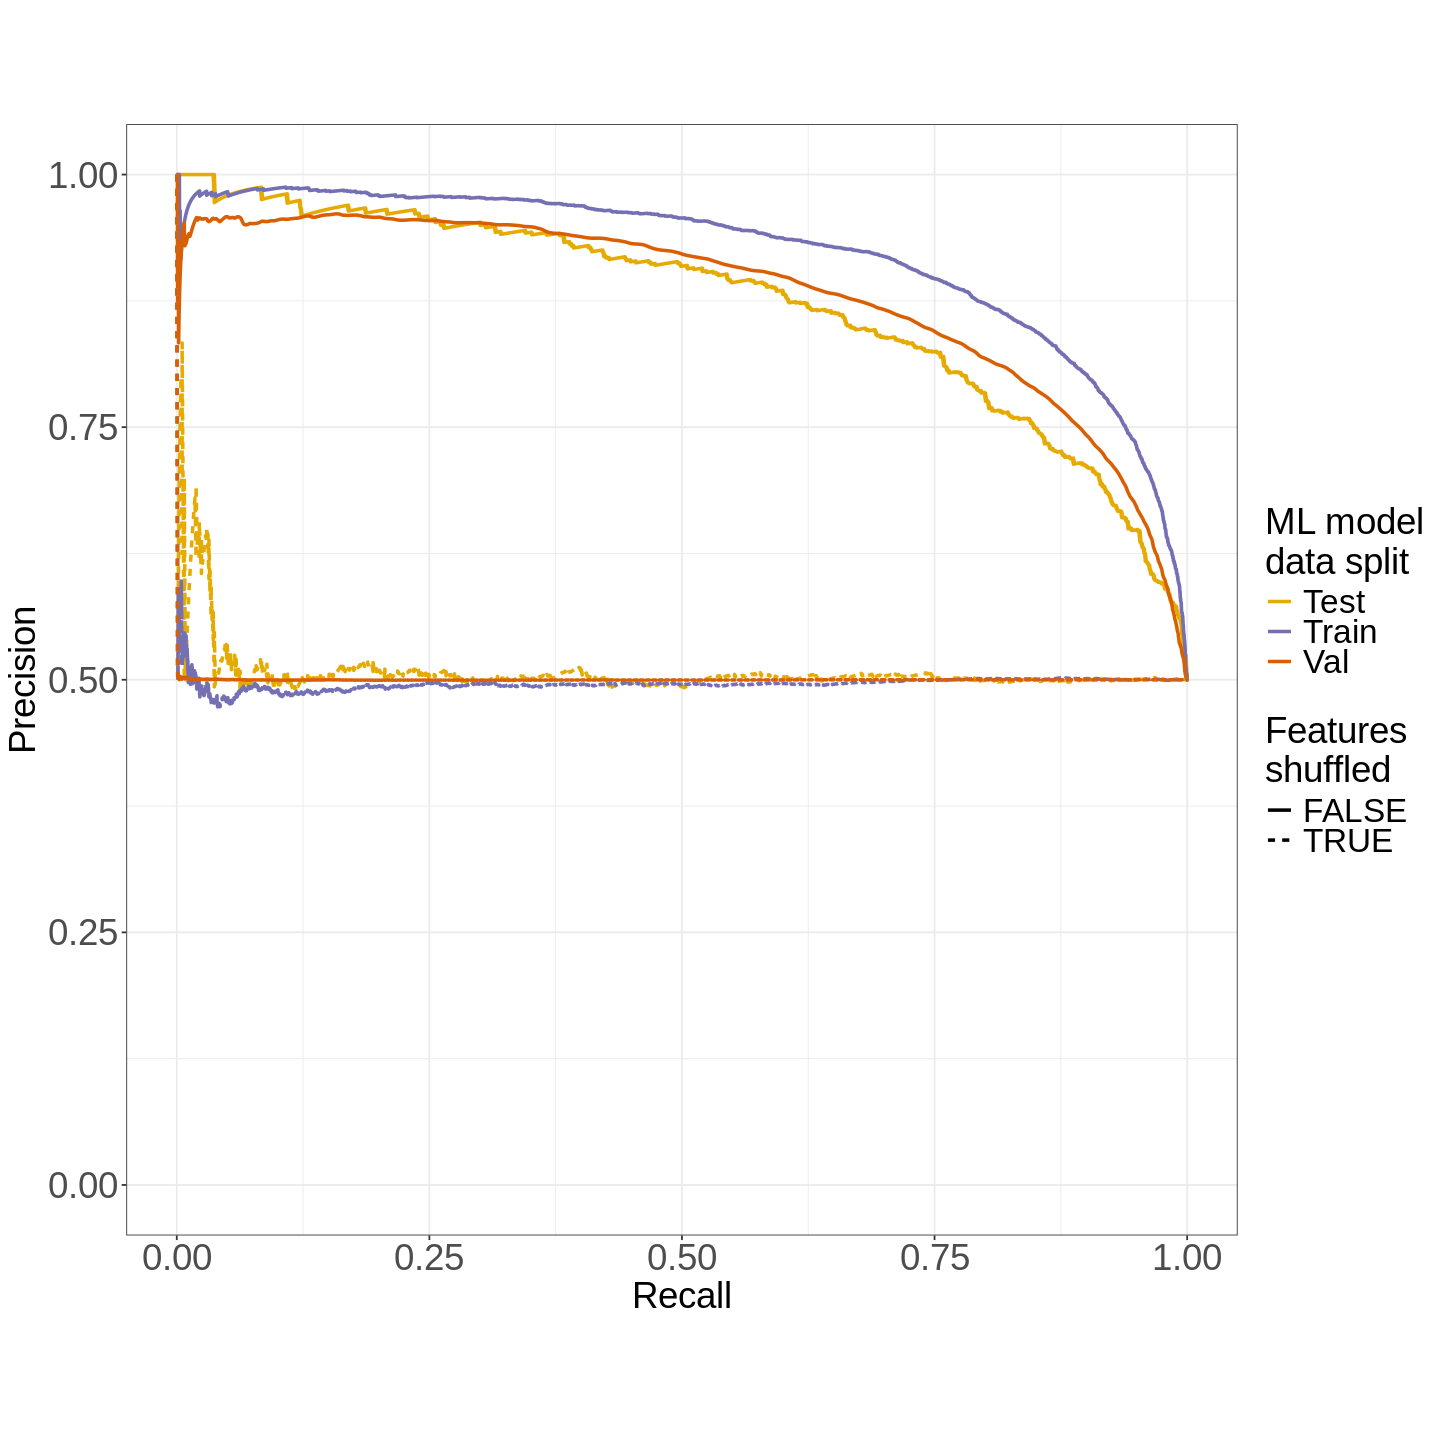

In [6]:
# Filter only rows with 'all_plates' in the 'plate' column
filtered_all_plates_pr_df <- PR_results_df[PR_results_df$plate == "all_plates", ]

width <- 12
height <- 12
options(repr.plot.width = width, repr.plot.height = height)
pr_all_plates_plot <- (
    ggplot(filtered_all_plates_pr_df, aes(x = recall, y = precision, color = datasplit, linetype = shuffled_type))
    + geom_line(aes(linetype = shuffled_type), linewidth = 1)
    + theme_bw()
    + coord_fixed()
    + labs(color = "ML model\ndata split", linetype = "Features\nshuffled", x = "Recall", y = "Precision")
    # change the colors
    + scale_color_manual(values = c(
        "Test" = brewer.pal(8, "Dark2")[6],
        "Train" = brewer.pal(8, "Dark2")[3],
        "Val" = brewer.pal(8, "Dark2")[2]
    ))
    + scale_y_continuous(limits = c(0, 1))
    # change the line thickness of the lines in the legend
    + guides(linetype = guide_legend(override.aes = list(size = 1)))  
    # change the text size
    + theme(
        # x and y axis text size
        axis.text.x = element_text(size = 22),
        axis.text.y = element_text(size = 22),
        # x and y axis title size
        axis.title.x = element_text(size = 22),
        axis.title.y = element_text(size = 22),
        # legend text size
        legend.text = element_text(size = 20),
        legend.title = element_text(size = 22),
    )
)

pr_all_plates_plot

## Load in metrics file (F1 scores and accuracy)

In [7]:
# Load data from original model evaluation
metrics_results_file <- file.path(results_dir, "metrics_final_qc_model.parquet")

metrics_results_df <- arrow::read_parquet(metrics_results_file)

# Filter out rows where datasplit is "val" or "shuffled_val"
metrics_results_df <- metrics_results_df %>%
    filter(!(datasplit %in% c("val", "shuffled_val")))

dim(metrics_results_df)
head(metrics_results_df)

[1] 16  6

f1_score,precision,recall,accuracy,plate,datasplit
<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
0.8473593,0.8456897,0.8490356,0.8470574,all_plates,train
0.8790053,0.8715031,0.8866377,0.8779547,Plate_3,train
0.8568399,0.8972793,0.8198884,0.8630137,Plate_3_prime,train
0.7735756,0.7496430,0.7990868,0.7661086,Plate_5,train
0.4935033,0.4963111,0.4907270,0.4963526,all_plates,shuffled_train
0.5006061,0.5031676,0.4980704,0.5031356,Plate_3,shuffled_train


### Update data frame to create new column for the data type (shuffled or final)

In [8]:
# Create new column for model using the datasplit prefix
metrics_results_df$shuffled_type <- ifelse(grepl("^shuffled_", metrics_results_df$datasplit), "TRUE", "FALSE")

# Remove "shuffled_" prefix from datasplit column for plotting
metrics_results_df$datasplit <- sub("^shuffled_", "", metrics_results_df$datasplit)

# Rename "data splits for interpretation
metrics_results_df <- metrics_results_df %>%
  mutate(datasplit = recode(datasplit, "test" = "Test", "train" = "Train"))

dim(metrics_results_df)
head(metrics_results_df)

[1] 16  7

f1_score,precision,recall,accuracy,plate,datasplit,shuffled_type
<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>
0.8473593,0.8456897,0.8490356,0.8470574,all_plates,Train,FALSE
0.8790053,0.8715031,0.8866377,0.8779547,Plate_3,Train,FALSE
0.8568399,0.8972793,0.8198884,0.8630137,Plate_3_prime,Train,FALSE
0.7735756,0.7496430,0.7990868,0.7661086,Plate_5,Train,FALSE
0.4935033,0.4963111,0.4907270,0.4963526,all_plates,Train,TRUE
0.5006061,0.5031676,0.4980704,0.5031356,Plate_3,Train,TRUE


## Create plots for  all plates using accuracy

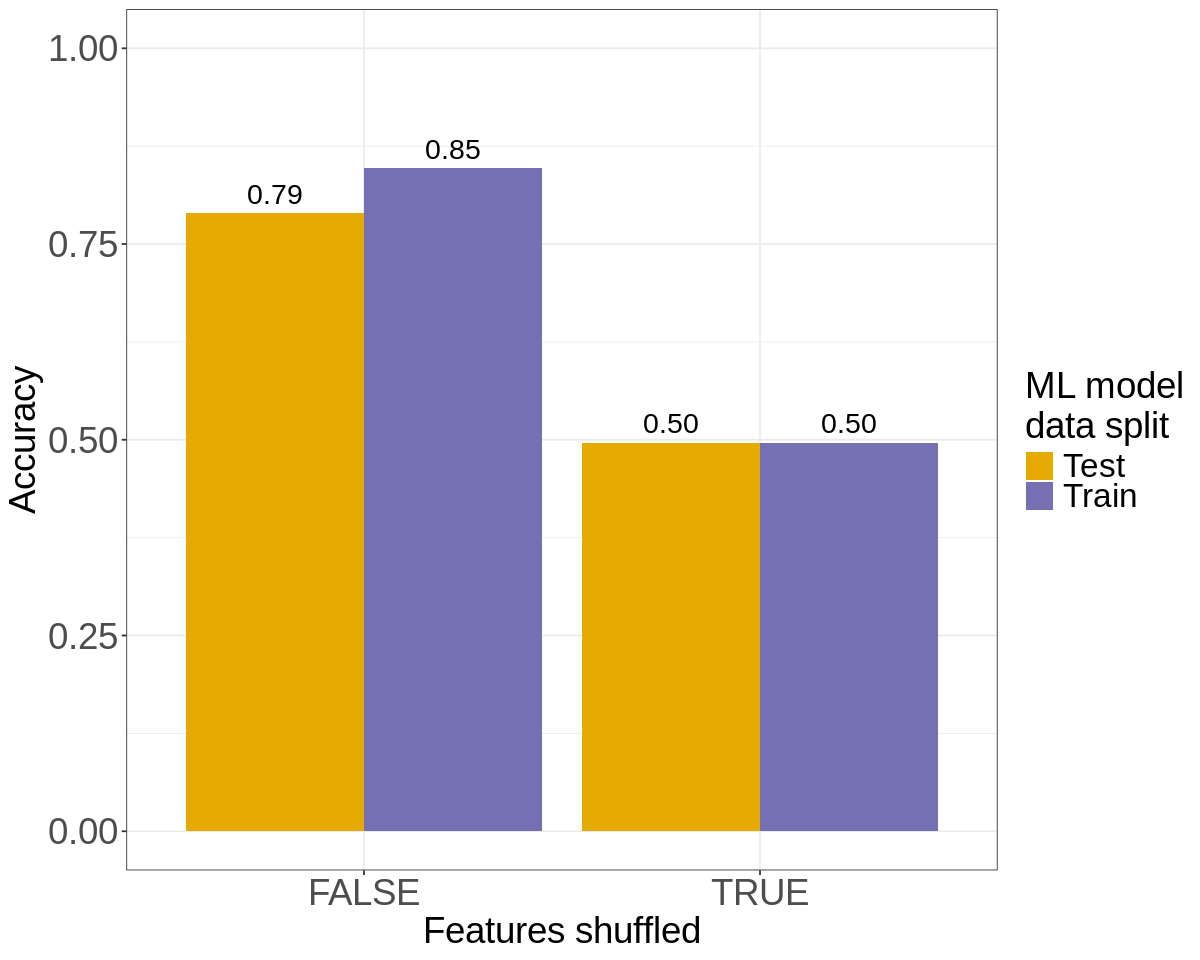

In [9]:
filtered_metrics_df <- metrics_results_df[metrics_results_df$plate == "all_plates", ]

width <- 10
height <- 8
options(repr.plot.width = width, repr.plot.height = height)
# bar plot of the accuracy scores
accuracy_score_all_plates_plot <- (
    ggplot(filtered_metrics_df, aes(x = shuffled_type, y = accuracy, fill = datasplit))
    + geom_bar(stat = "identity", position = "dodge")

    # Add text labels for accuracy scores on top of bars
    + geom_text(
        aes(label = sprintf("%.2f", accuracy)), 
        position = position_dodge(width = 0.9), 
        vjust = -0.5, 
        size = 6
    )

    + ylim(0, 1)
    + theme_bw()
    + ylab("Accuracy")
    + xlab("Features shuffled")
    # change the legend title
    + labs(fill = "ML model\ndata split")
    # change the colours
    + scale_fill_manual(values = c(
        "Test" = brewer.pal(8, "Dark2")[6],
        "Train" = brewer.pal(8, "Dark2")[3]
    ))
    # change the text size
    + theme(
        # x and y axis text size
        axis.text.x = element_text(size = 22),
        axis.text.y = element_text(size = 22),
        # x and y axis title size
        axis.title.x = element_text(size = 22),
        axis.title.y = element_text(size = 22),
        # legend text size
        legend.text = element_text(size = 20),
        legend.title = element_text(size = 22),
    )
)

accuracy_score_all_plates_plot

## Load in confusion matrix data

In [10]:
# Load data for original model evaluation
CM_results_file <- file.path(results_dir, "confusion_matrix_final_qc_model.parquet")

CM_results_df <- arrow::read_parquet(CM_results_file)

# Filter out rows where datasplit is "val" or "shuffled_val"
CM_results_df <- CM_results_df %>%
    filter(!(datasplit %in% c("val", "shuffled_val")))

# Update the true_genotype and predicted_genotype columns
CM_results_df <- CM_results_df %>%
  dplyr::mutate(
    true_genotype = dplyr::recode(true_genotype,
                                  Null = "Null C04",
                                  WT = "WT A3"),
    predicted_genotype = dplyr::recode(predicted_genotype,
                                      Null = "Null C04",
                                      WT = "WT A3")
  )

dim(CM_results_df)
head(CM_results_df)

[1] 64  5

confusion_values,true_genotype,predicted_genotype,plate,datasplit
<int>,<chr>,<chr>,<chr>,<chr>
6835,Null C04,Null C04,all_plates,train
1253,Null C04,WT A3,all_plates,train
1221,WT A3,Null C04,all_plates,train
6867,WT A3,WT A3,all_plates,train
3604,Null C04,Null C04,Plate_3,train
542,Null C04,WT A3,Plate_3,train


### Update data frame to create new column for the data type (shuffled or final)

In [11]:
# Create new column for model using the datasplit prefix
CM_results_df$shuffled_type <- ifelse(grepl("^shuffled_", CM_results_df$datasplit), "TRUE", "FALSE")

# Remove "shuffled_" prefix from datasplit column for plotting
CM_results_df$datasplit <- sub("^shuffled_", "", CM_results_df$datasplit)

# Rename "data splits for interpretation
CM_results_df <- CM_results_df %>%
  mutate(datasplit = recode(datasplit, "test" = "Test", "train" = "Train"))

dim(CM_results_df)
head(CM_results_df)

[1] 64  6

confusion_values,true_genotype,predicted_genotype,plate,datasplit,shuffled_type
<int>,<chr>,<chr>,<chr>,<chr>,<chr>
6835,Null C04,Null C04,all_plates,Train,FALSE
1253,Null C04,WT A3,all_plates,Train,FALSE
1221,WT A3,Null C04,all_plates,Train,FALSE
6867,WT A3,WT A3,all_plates,Train,FALSE
3604,Null C04,Null C04,Plate_3,Train,FALSE
542,Null C04,WT A3,Plate_3,Train,FALSE


### Add ratio of confusion values to the total count

In [12]:
CM_results_df <- CM_results_df %>%
  dplyr::group_by(true_genotype, plate, datasplit, shuffled_type) %>%
  dplyr::mutate(
    total_count = sum(confusion_values),
    ratio = confusion_values / total_count
  )

dim(CM_results_df)
head(CM_results_df)

[1] 64  8

confusion_values,true_genotype,predicted_genotype,plate,datasplit,shuffled_type,total_count,ratio
<int>,<chr>,<chr>,<chr>,<chr>,<chr>,<int>,<dbl>
6835,Null C04,Null C04,all_plates,Train,FALSE,8088,0.8450791
1253,Null C04,WT A3,all_plates,Train,FALSE,8088,0.1549209
1221,WT A3,Null C04,all_plates,Train,FALSE,8088,0.1509644
6867,WT A3,WT A3,all_plates,Train,FALSE,8088,0.8490356
3604,Null C04,Null C04,Plate_3,Train,FALSE,4146,0.8692716
542,Null C04,WT A3,Plate_3,Train,FALSE,4146,0.1307284


## Create confusion matrix plots for all plates

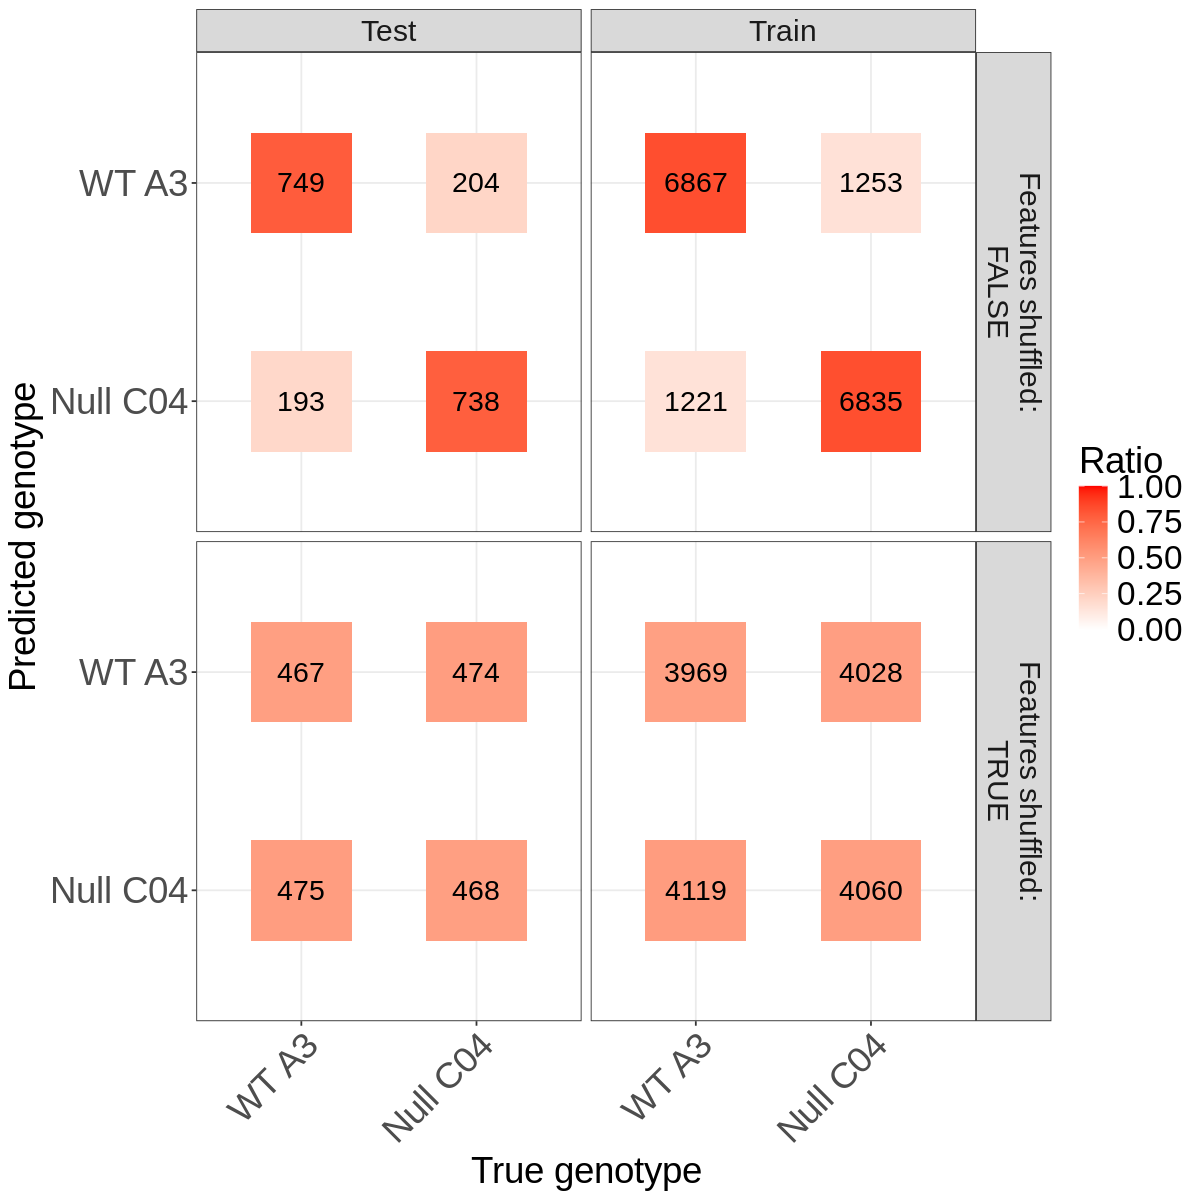

In [13]:
# Filter only rows with plate with "all_plates"
filtered_CM_df <- CM_results_df[(CM_results_df$plate == "all_plates"), ]

# plot dimensions
width <- 10
height <- 10
options(repr.plot.width = width, repr.plot.height = height)

# Custom labeller function
custom_labeller <- as_labeller(c(
  "Test" = "Test",
  "Train" = "Train",
  "FALSE" = "Features shuffled:\nFALSE",
  "TRUE" = "Features shuffled:\nTRUE"
))

# plot a confusion matrix
confusion_matrix_all_plates_plot <- (
    ggplot(filtered_CM_df, aes(x = factor(true_genotype, levels = rev(levels(factor(true_genotype)))), y = predicted_genotype)) +
    facet_grid(shuffled_type ~ datasplit, labeller = custom_labeller) +
    geom_point(aes(color = ratio), size = 28, shape = 15) +
    geom_text(aes(label = confusion_values), size = 6) +
    scale_color_gradient("Ratio", low = "white", high = "red", limits = c(0, 1)) +
    theme_bw() +
    ylab("Predicted genotype") +
    xlab("True genotype") +
    # change the text size
    theme(
        strip.text = element_text(size = 18),
        # x and y axis text size
        axis.text.x = element_text(size = 22, angle = 45, hjust = 1),
        axis.text.y = element_text(size = 22),
        # x and y axis title size
        axis.title.x = element_text(size = 22),
        axis.title.y = element_text(size = 22),
        # legend text size
        legend.text = element_text(size = 20),
        legend.title = element_text(size = 22),
    )
)

confusion_matrix_all_plates_plot


## Generate PR curve with the new model which includes plate with both derivatives

In [14]:
# Directory for PR results from new (derivation) model
results_dir <- file.path(
    "../../1.train_models/train_deriv_model/pr_results"
)

# Load data
PR_results_file <- file.path(results_dir, "precision_recall_final_model.parquet")

PR_results_df <- arrow::read_parquet(PR_results_file)

# Create new column for model using the datasplit prefix
PR_results_df <- PR_results_df %>%
  mutate(shuffled_type = ifelse(grepl("^shuffled_", datasplit), "TRUE", "FALSE"))

# Remove "shuffled_" prefix from datasplit column for plotting
PR_results_df <- PR_results_df %>%
  mutate(datasplit = sub("^shuffled_", "", datasplit))

# Rename "data splits for interpretation
PR_results_df <- PR_results_df %>%
  mutate(datasplit = recode(datasplit, "test" = "Test", "train" = "Train", "val" = "Val"))

dim(PR_results_df)
head(PR_results_df)

[1] 41439016        5

precision,recall,plate,datasplit,shuffled_type
<dbl>,<dbl>,<chr>,<chr>,<chr>
0.5000000,1.0000000,all_plates,Val,FALSE
0.4999999,0.9999998,all_plates,Val,FALSE
0.4999999,0.9999996,all_plates,Val,FALSE
0.4999998,0.9999994,all_plates,Val,FALSE
0.4999998,0.9999992,all_plates,Val,FALSE
0.4999997,0.9999990,all_plates,Val,FALSE


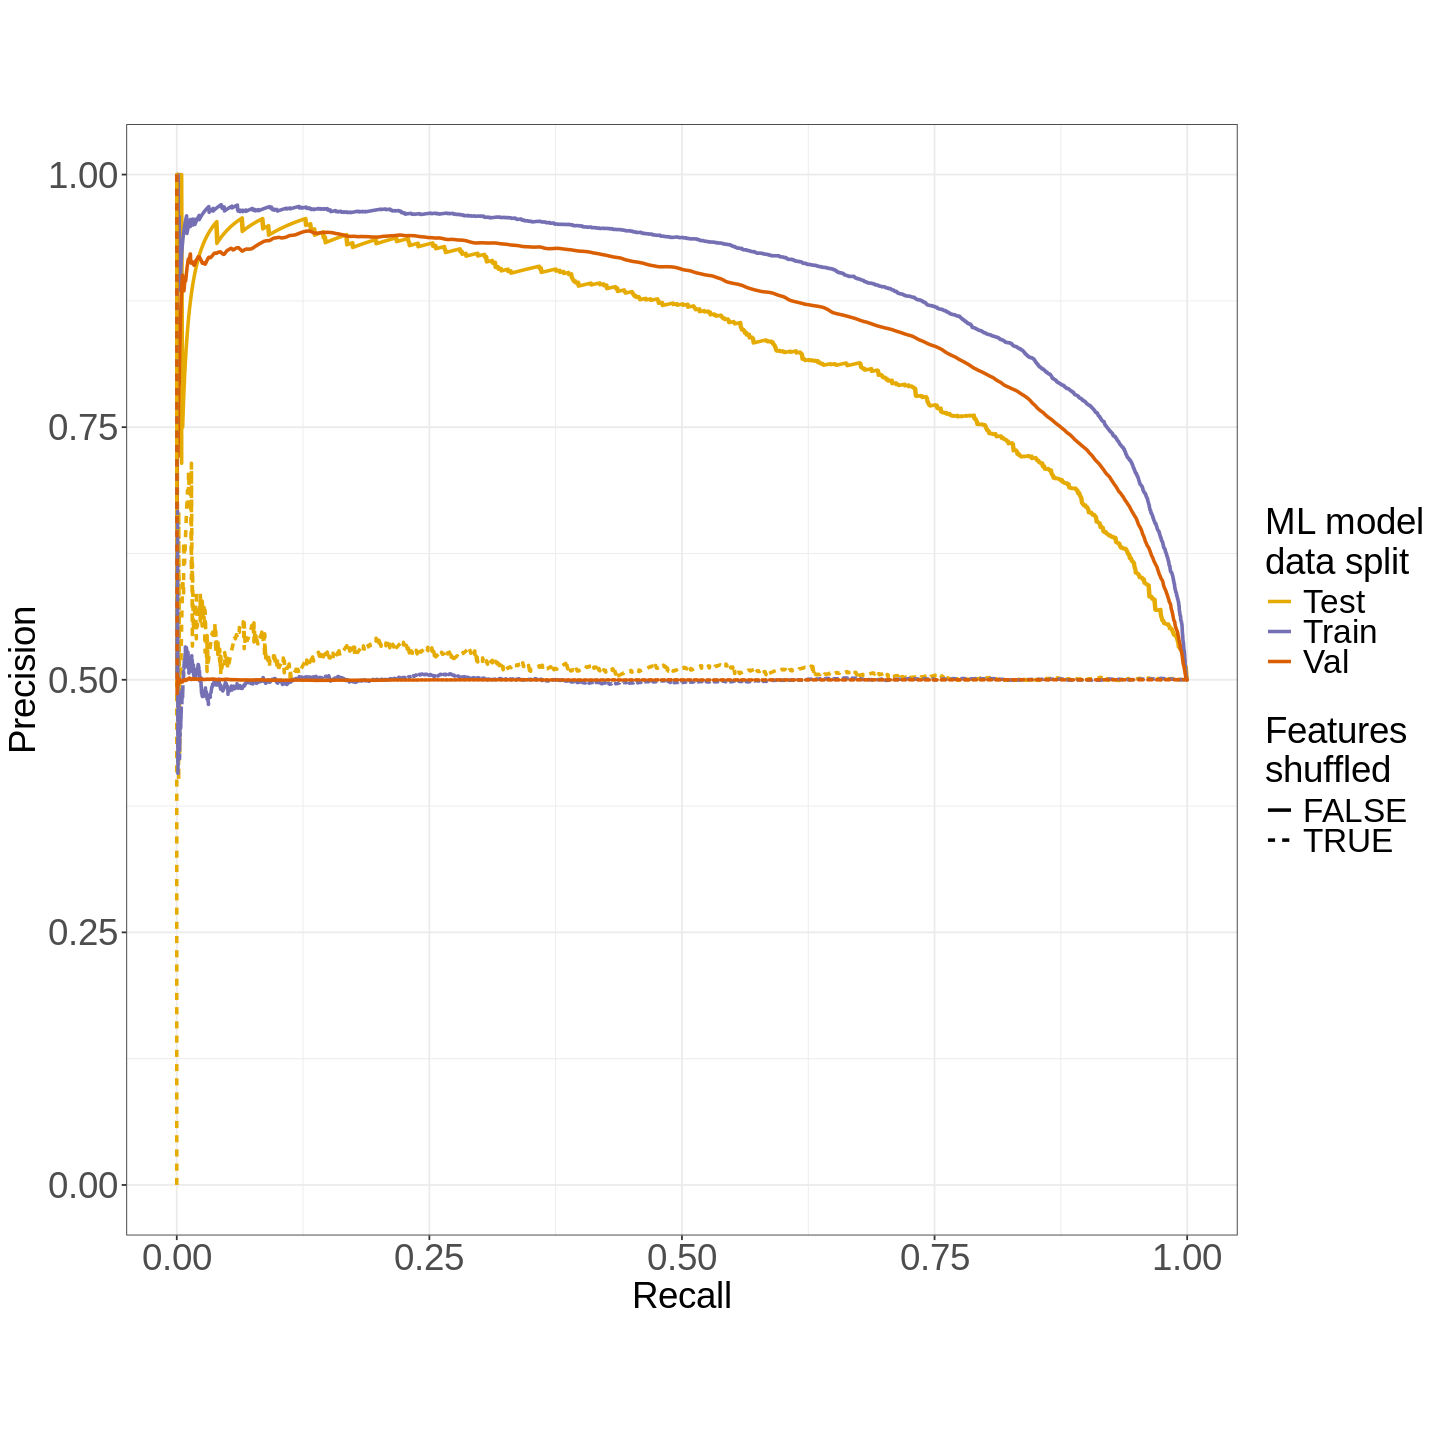

In [15]:
# Filter only rows with 'all_plates' in the 'plate' column
filtered_all_plates_pr_df <- PR_results_df[PR_results_df$plate == "all_plates", ]

width <- 12
height <- 12
options(repr.plot.width = width, repr.plot.height = height)
pr_new_model_all_plates_plot <- (
    ggplot(filtered_all_plates_pr_df, aes(x = recall, y = precision, color = datasplit, linetype = shuffled_type))
    + geom_line(aes(linetype = shuffled_type), linewidth = 1)
    + theme_bw()
    + coord_fixed()
    + labs(color = "ML model\ndata split", linetype = "Features\nshuffled", x = "Recall", y = "Precision")
    # change the colors
    + scale_color_manual(values = c(
        "Test" = brewer.pal(8, "Dark2")[6],
        "Train" = brewer.pal(8, "Dark2")[3],
        "Val" = brewer.pal(8, "Dark2")[2]
    ))
    + scale_y_continuous(limits = c(0, 1))
    # change the line thickness of the lines in the legend
    + guides(linetype = guide_legend(override.aes = list(size = 1)))  
    # change the text size
    + theme(
        # x and y axis text size
        axis.text.x = element_text(size = 22),
        axis.text.y = element_text(size = 22),
        # x and y axis title size
        axis.title.x = element_text(size = 22),
        axis.title.y = element_text(size = 22),
        # legend text size
        legend.text = element_text(size = 20),
        legend.title = element_text(size = 22),
    )
)

pr_new_model_all_plates_plot

### Generate plot with just the derivatives from Plate_6

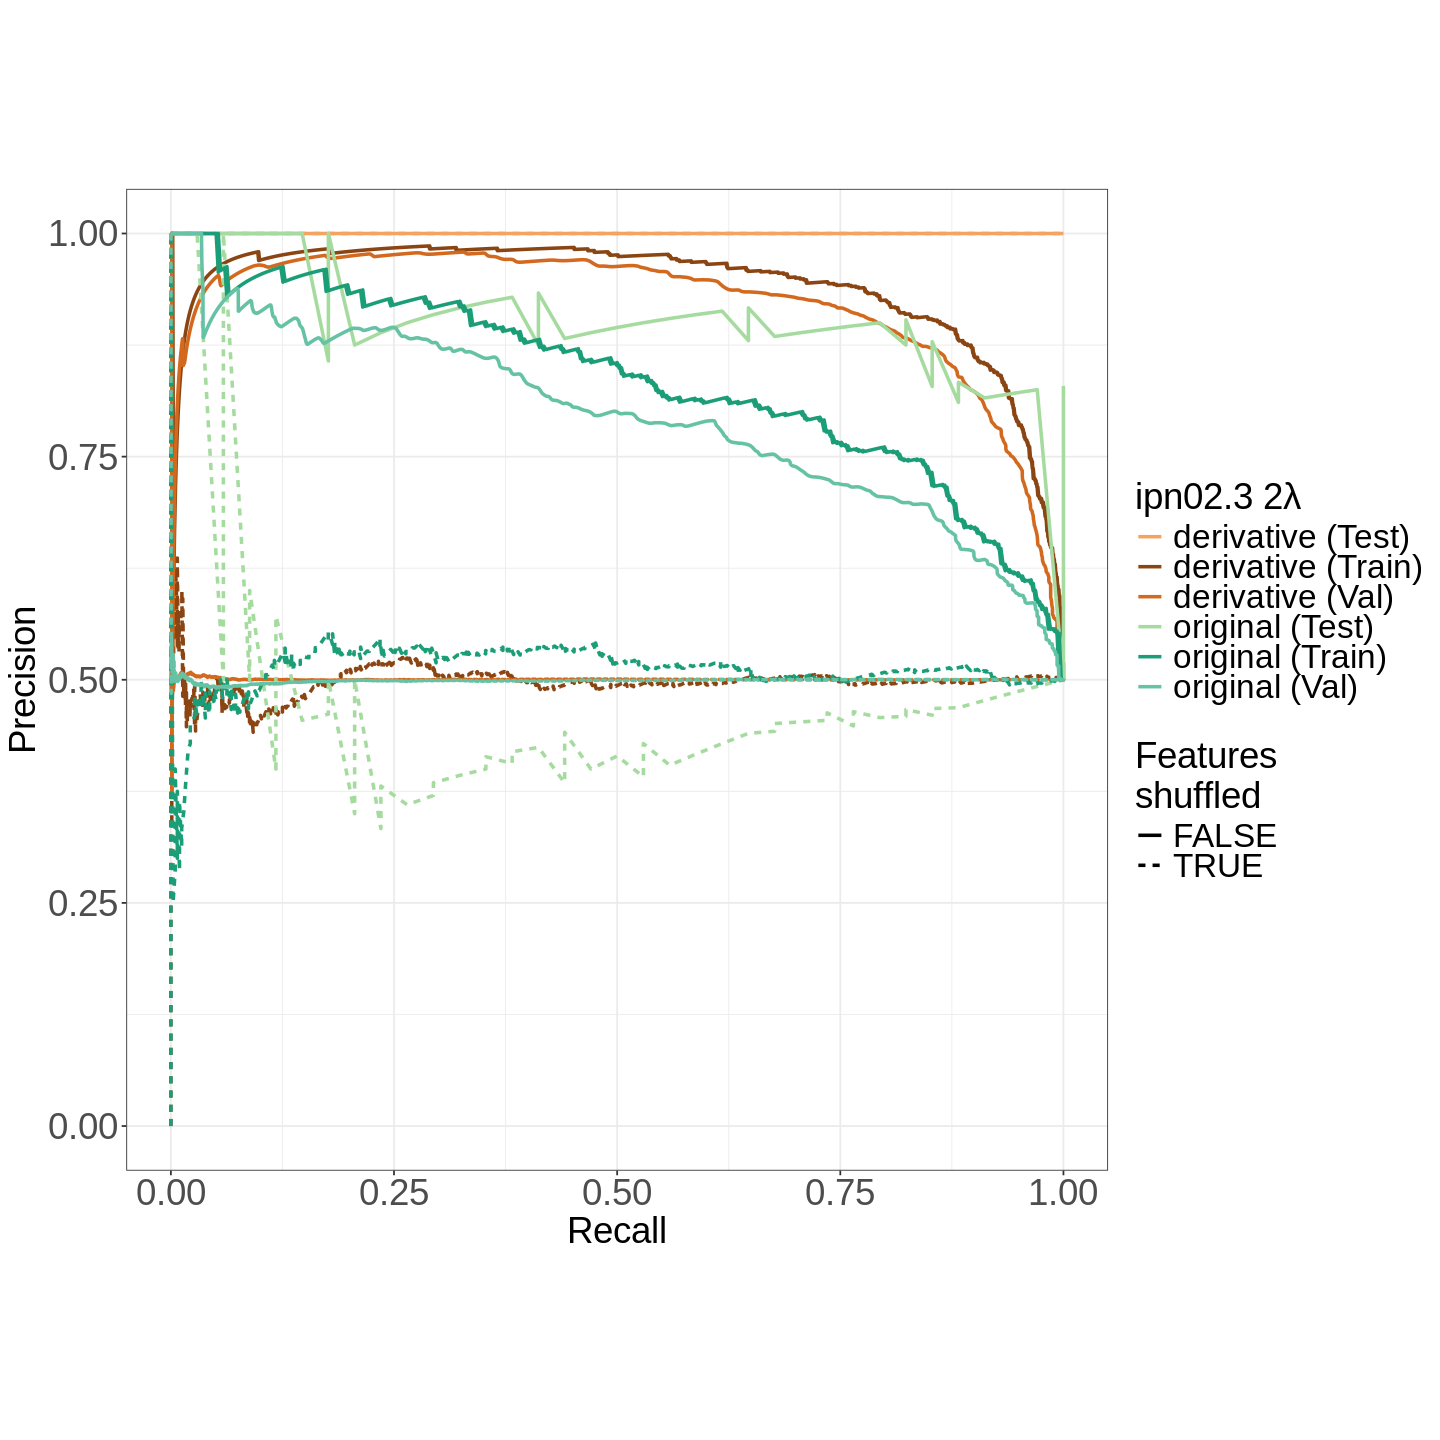

In [16]:
# Filter only rows with 'Plate_6_orig' and `Plate_6_deriv' in the 'plate' column
filtered_plate_6_pr_df <- PR_results_df[PR_results_df$plate %in% c("Plate_6_orig", "Plate_6_deriv"), ]

# Add new column for derivative type
filtered_plate_6_pr_df <- filtered_plate_6_pr_df %>%
    mutate(
        derivative_type = ifelse(plate == "Plate_6_orig", "original", "derivative"),
        group_type = paste0(derivative_type, " (", datasplit, ")") # Add datasplit to group_type
        )

width <- 12
height <- 12
options(repr.plot.width = width, repr.plot.height = height)
pr_plate_6_deriv_plot <- (
    ggplot(filtered_plate_6_pr_df, aes(x = recall, y = precision, color = group_type, linetype = shuffled_type))
    + geom_line(linewidth = 1)
    + theme_bw()
    + coord_fixed()
    + labs(color = "ipn02.3 2λ", linetype = "Features\nshuffled", x = "Recall", y = "Precision")
    # change the colors
    + scale_color_manual(values = c(
        "original (Train)" = "#1b9e77",      # dark green
        "original (Val)"   = "#66c2a5",      # medium green
        "original (Test)"  = "#a6dba0",      # light green
        "derivative (Train)" = "#8B4513",    # dark brown (saddle brown)
        "derivative (Val)"   = "#D2691E",    # chocolate
        "derivative (Test)"  = "#F4A460"     # sandy brown
    ))
    + scale_y_continuous(limits = c(0, 1))
    # change the line thickness of the lines in the legend
    + guides(linetype = guide_legend(override.aes = list(size = 1)))  
    # change the text size
    + theme(
        # x and y axis text size
        axis.text.x = element_text(size = 22),
        axis.text.y = element_text(size = 22),
        # x and y axis title size
        axis.title.x = element_text(size = 22),
        axis.title.y = element_text(size = 22),
        # legend text size
        legend.text = element_text(size = 20),
        legend.title = element_text(size = 22),
    )
)

pr_plate_6_deriv_plot

In [17]:
filtered_plate_6_pr_df %>%
    count(group_type)


group_type,n
<chr>,<int>
derivative (Test),118
derivative (Train),3906
derivative (Val),1951474
original (Test),138
original (Train),1658
original (Val),827798


## Plot the comparison between the original and new model coefficients

In [18]:
# Load the merged coefficients file
merged_coefficients_file <- "../../1.train_models/train_deriv_model/coeff_results/merged_coefficients_original_new_model.csv"

if (file.exists(merged_coefficients_file)) {
    merged_coefficients <- read.csv(merged_coefficients_file)
    cat("Merged coefficients file loaded successfully.\n")
} else {
    stop("File not found:", merged_coefficients_file)
}

# Split the feature column into parts to add back as columns
feature_parts <- strsplit(merged_coefficients$feature, "_")

# Add feature parts as columns
merged_coefficients$compartment <- sapply(feature_parts, `[`, 1)
merged_coefficients$feature_group <- sapply(feature_parts, `[`, 2)
merged_coefficients$measurement <- sapply(feature_parts, `[`, 3)
merged_coefficients$organelle <- sapply(feature_parts, `[`, 4)
merged_coefficients$parameter1 <- sapply(feature_parts, `[`, 5)
merged_coefficients$parameter2 <- sapply(feature_parts, `[`, 6)
merged_coefficients$parameter3 <- sapply(feature_parts, `[`, 7)

# Replace invalid organelle values with "other"
merged_coefficients$organelle <- ifelse(
    is.na(merged_coefficients$organelle) |
        grepl("^[0-9]+$", merged_coefficients$organelle) |
        merged_coefficients$organelle %in% c("Adjacent", "X", "Y"),
    "other",
    merged_coefficients$organelle
)

# Update organelle names based on channel
merged_coefficients$organelle <- dplyr::recode(
    merged_coefficients$organelle,
    "DAPI" = "Nucleus",
    "GFP" = "ER",
    "RFP" = "Actin",
    "CY5" = "Mito",
    .default = merged_coefficients$organelle
)

# Display the first few rows of the loaded data
head(merged_coefficients)

Merged coefficients file loaded successfully.


,feature,coefficient_orig_model,coefficient_new_model,compartment,feature_group,measurement,organelle,parameter1,parameter2,parameter3
,<chr>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
1,Cytoplasm_RadialDistribution_ZernikePhase_GFP_7_3,0.04142596,0.013048217,Cytoplasm,RadialDistribution,ZernikePhase,ER,7,3,NA
2,Nuclei_RadialDistribution_ZernikePhase_CY5_7_5,0.02497480,0.050109866,Nuclei,RadialDistribution,ZernikePhase,Mito,7,5,NA
3,Nuclei_RadialDistribution_ZernikePhase_RFP_7_7,-0.01141866,0.009036408,Nuclei,RadialDistribution,ZernikePhase,Actin,7,7,NA
4,Nuclei_RadialDistribution_ZernikeMagnitude_RFP_5_3,-0.05373913,-0.027614007,Nuclei,RadialDistribution,ZernikeMagnitude,Actin,5,3,NA
5,Cells_RadialDistribution_RadialCV_GFP_1of4,0.01997790,0.013382433,Cells,RadialDistribution,RadialCV,ER,1of4,NA,NA
6,Nuclei_Intensity_LowerQuartileIntensity_GFP,-0.60101071,-0.419767783,Nuclei,Intensity,LowerQuartileIntensity,ER,NA,NA,NA


In [19]:
# Top 3 features in the original model
top3_orig <- merged_coefficients %>%
    arrange(desc(abs(coefficient_orig_model))) %>%
    slice_head(n = 3) %>%
    select(feature, coefficient_orig_model)

cat("Top 3 features in the Original Model:\n")
print(top3_orig)

# Top 3 features in the new model
top3_new <- merged_coefficients %>%
    arrange(desc(abs(coefficient_new_model))) %>%
    slice_head(n = 3) %>%
    select(feature, coefficient_new_model)

cat("\nTop 3 features in the New Model:\n")
print(top3_new)

Top 3 features in the Original Model:
                                        feature coefficient_orig_model
1   Nuclei_RadialDistribution_FracAtD_DAPI_4of4               3.640308
2    Nuclei_RadialDistribution_FracAtD_CY5_2of4               2.283346
3 Cytoplasm_RadialDistribution_FracAtD_RFP_4of4              -2.142580

Top 3 features in the New Model:
                                           feature coefficient_new_model
1      Nuclei_RadialDistribution_FracAtD_DAPI_4of4              2.181626
2       Nuclei_RadialDistribution_FracAtD_RFP_4of4             -1.992575
3 Cytoplasm_Intensity_IntegratedIntensityEdge_DAPI             -1.626386


In [20]:
# Get top 10 features by absolute value for each model
top10_new <- merged_coefficients %>%
    arrange(desc(abs(coefficient_new_model))) %>%
    slice(1:10) %>%
    pull(feature)

top10_orig <- merged_coefficients %>%
    arrange(desc(abs(coefficient_orig_model))) %>%
    slice(1:10) %>%
    pull(feature)

# Find intersection and count
common_features <- intersect(top10_new, top10_orig)
num_common <- length(common_features)

cat("Number of overlapping top 10 features between both models:", num_common, "\n")
cat("Common features:\n")
print(common_features)

Number of overlapping top 10 features between both models: 7 
Common features:
[1] "Nuclei_RadialDistribution_FracAtD_DAPI_4of4"     
[2] "Nuclei_RadialDistribution_FracAtD_RFP_4of4"      
[3] "Cytoplasm_Intensity_IntegratedIntensityEdge_DAPI"
[4] "Cells_Correlation_Correlation_DAPI_GFP"          
[5] "Cytoplasm_RadialDistribution_FracAtD_RFP_4of4"   
[6] "Nuclei_RadialDistribution_FracAtD_CY5_2of4"      
[7] "Nuclei_RadialDistribution_FracAtD_CY5_3of4"      


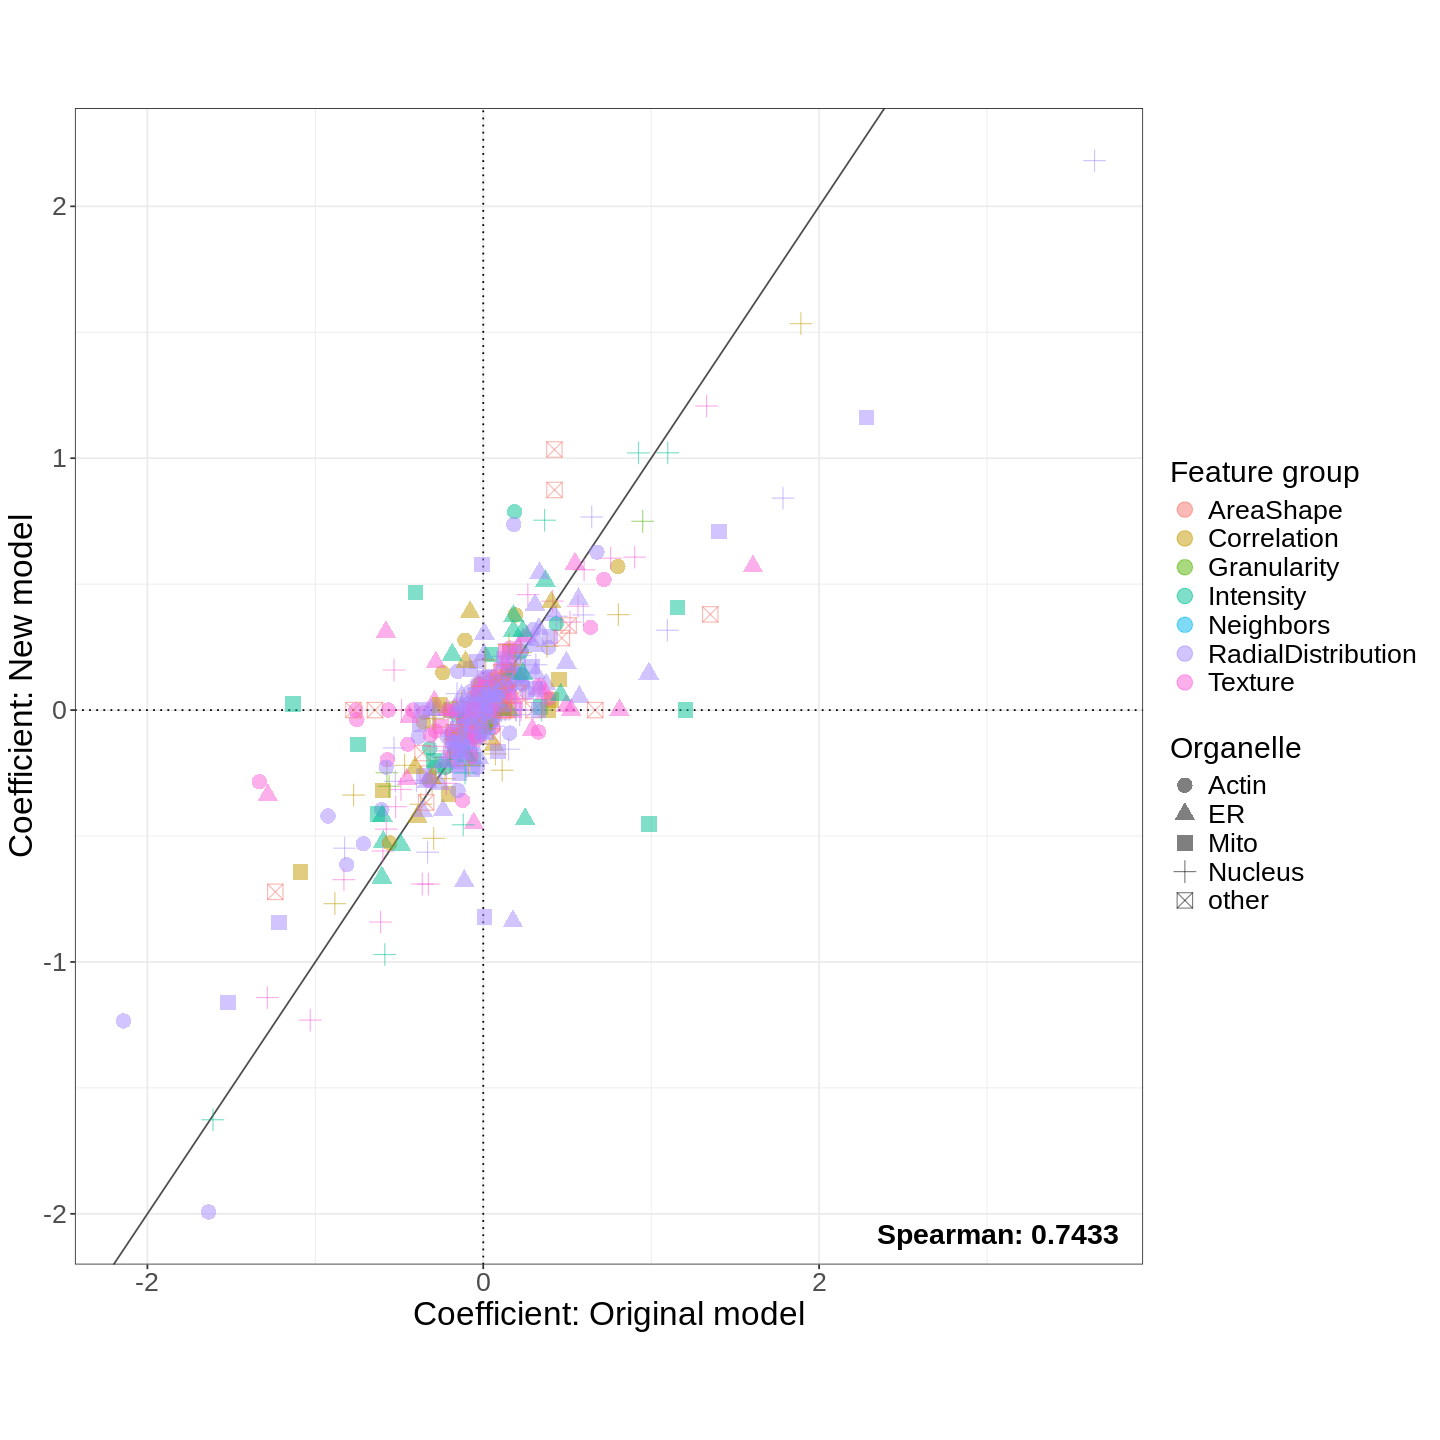

In [21]:
# Set height and width of plot for visualizing
width <- 12
height <- 12
options(repr.plot.width = width, repr.plot.height = height)

# Generate scatterplot of coefficients
scatterplot_models <- ggplot(merged_coefficients, aes(
    x = coefficient_orig_model, y = coefficient_new_model,
    color = feature_group, shape = organelle
)) +
    coord_fixed(ratio = 1.5) +
    geom_vline(xintercept = 0, linetype = "dotted", color = "black") +
    geom_hline(yintercept = 0, linetype = "dotted", color = "black") +
    geom_abline(slope = 1, intercept = 0, linetype = "solid", color = "gray30") +
    geom_point(size = 4, alpha = 0.5) +
    annotate("text", x = Inf, y = -Inf, 
         label = paste0("Spearman: 0.7433"),
         hjust = 1.1, vjust = -1.1, size = 6, color = "black", fontface = "bold") +
    theme_bw() +
    theme(
        text = element_text(size = 18),
        axis.title = element_text(size = 20),
        axis.text = element_text(size = 16),
        legend.title = element_text(size = 18),
        legend.text = element_text(size = 16)
    ) +
    labs(
        x = "Coefficient: Original model",
        y = "Coefficient: New model",
        color = "Feature group",
        shape = "Organelle"
    )

scatterplot_models

## Create main figure 3 by patchworking plots together

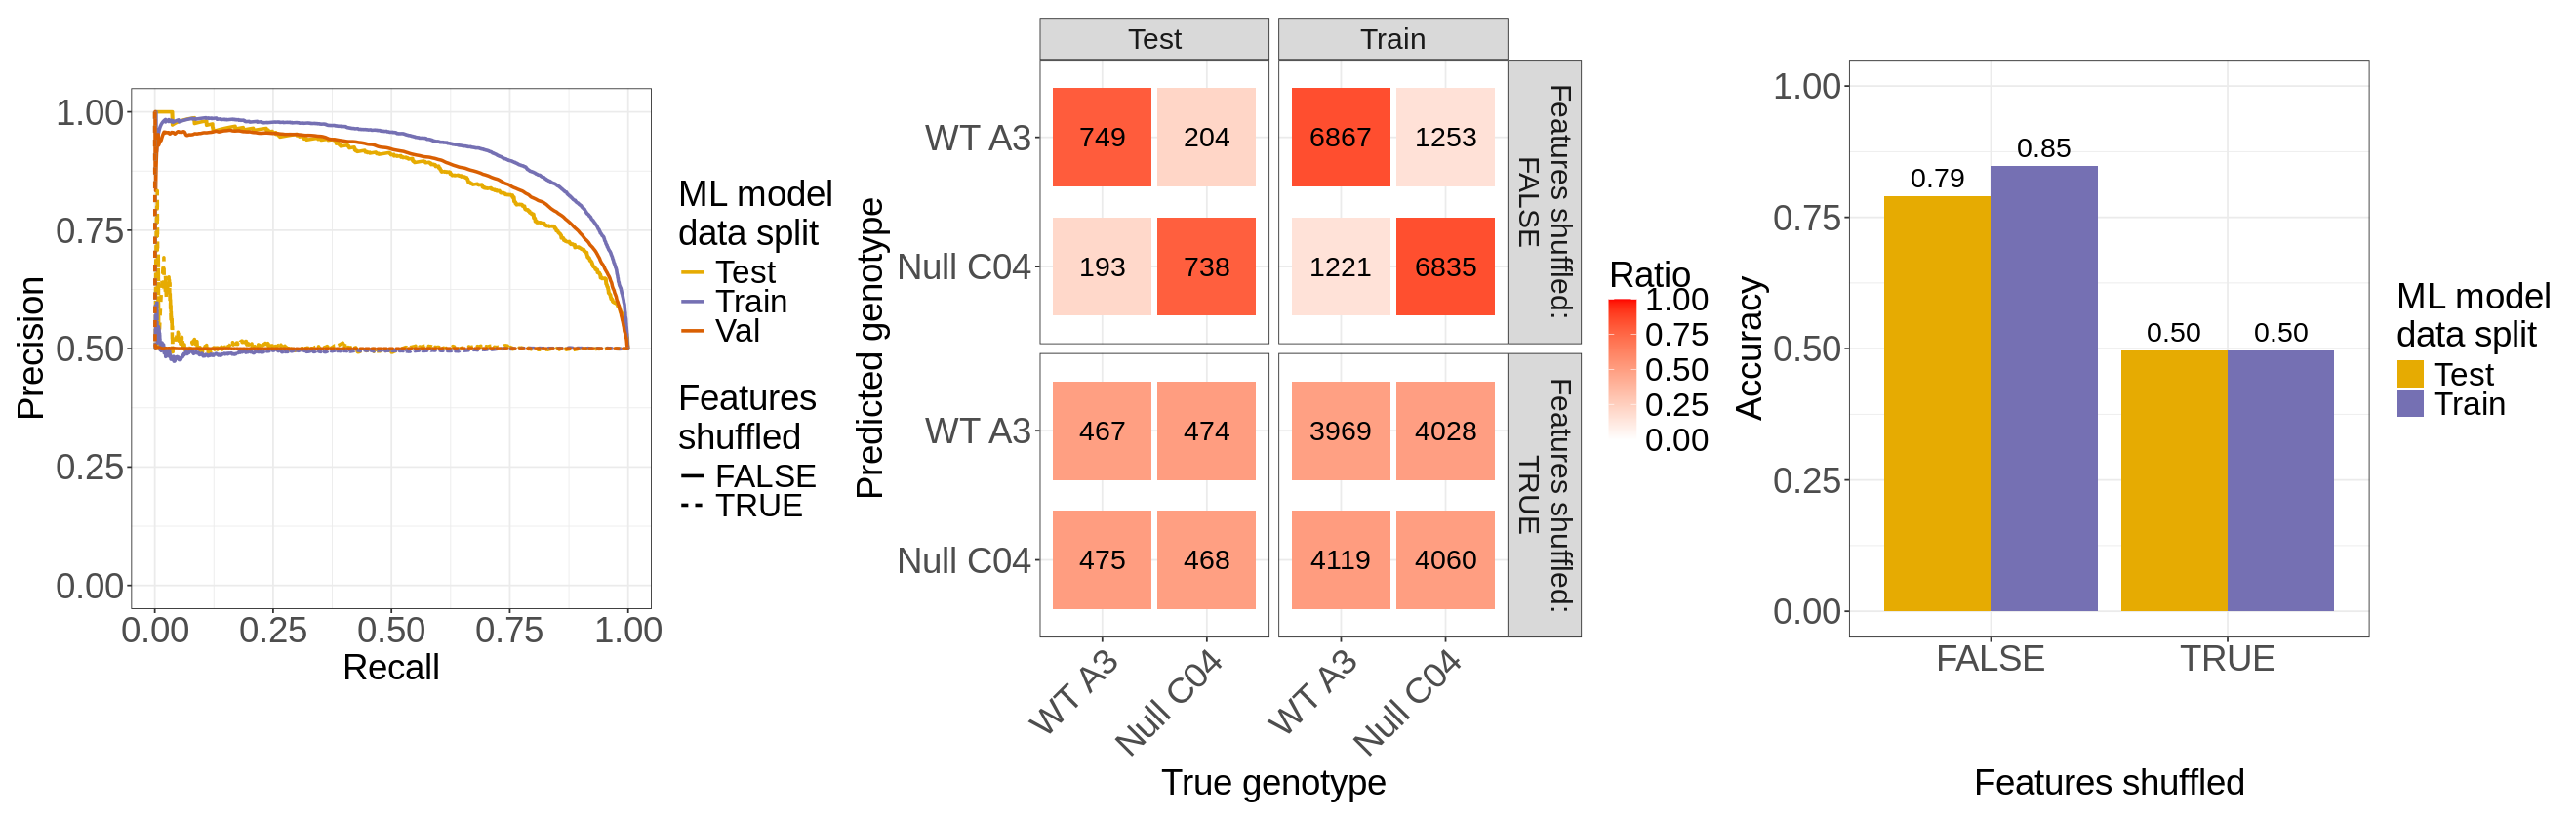

In [22]:
width <- 22
height <- 7
options(repr.plot.width = width, repr.plot.height = height)

top_plot <- (
    pr_all_plates_plot |
    confusion_matrix_all_plates_plot |
    accuracy_score_all_plates_plot
) + plot_layout(widths = c(2,1.8,2))

top_plot

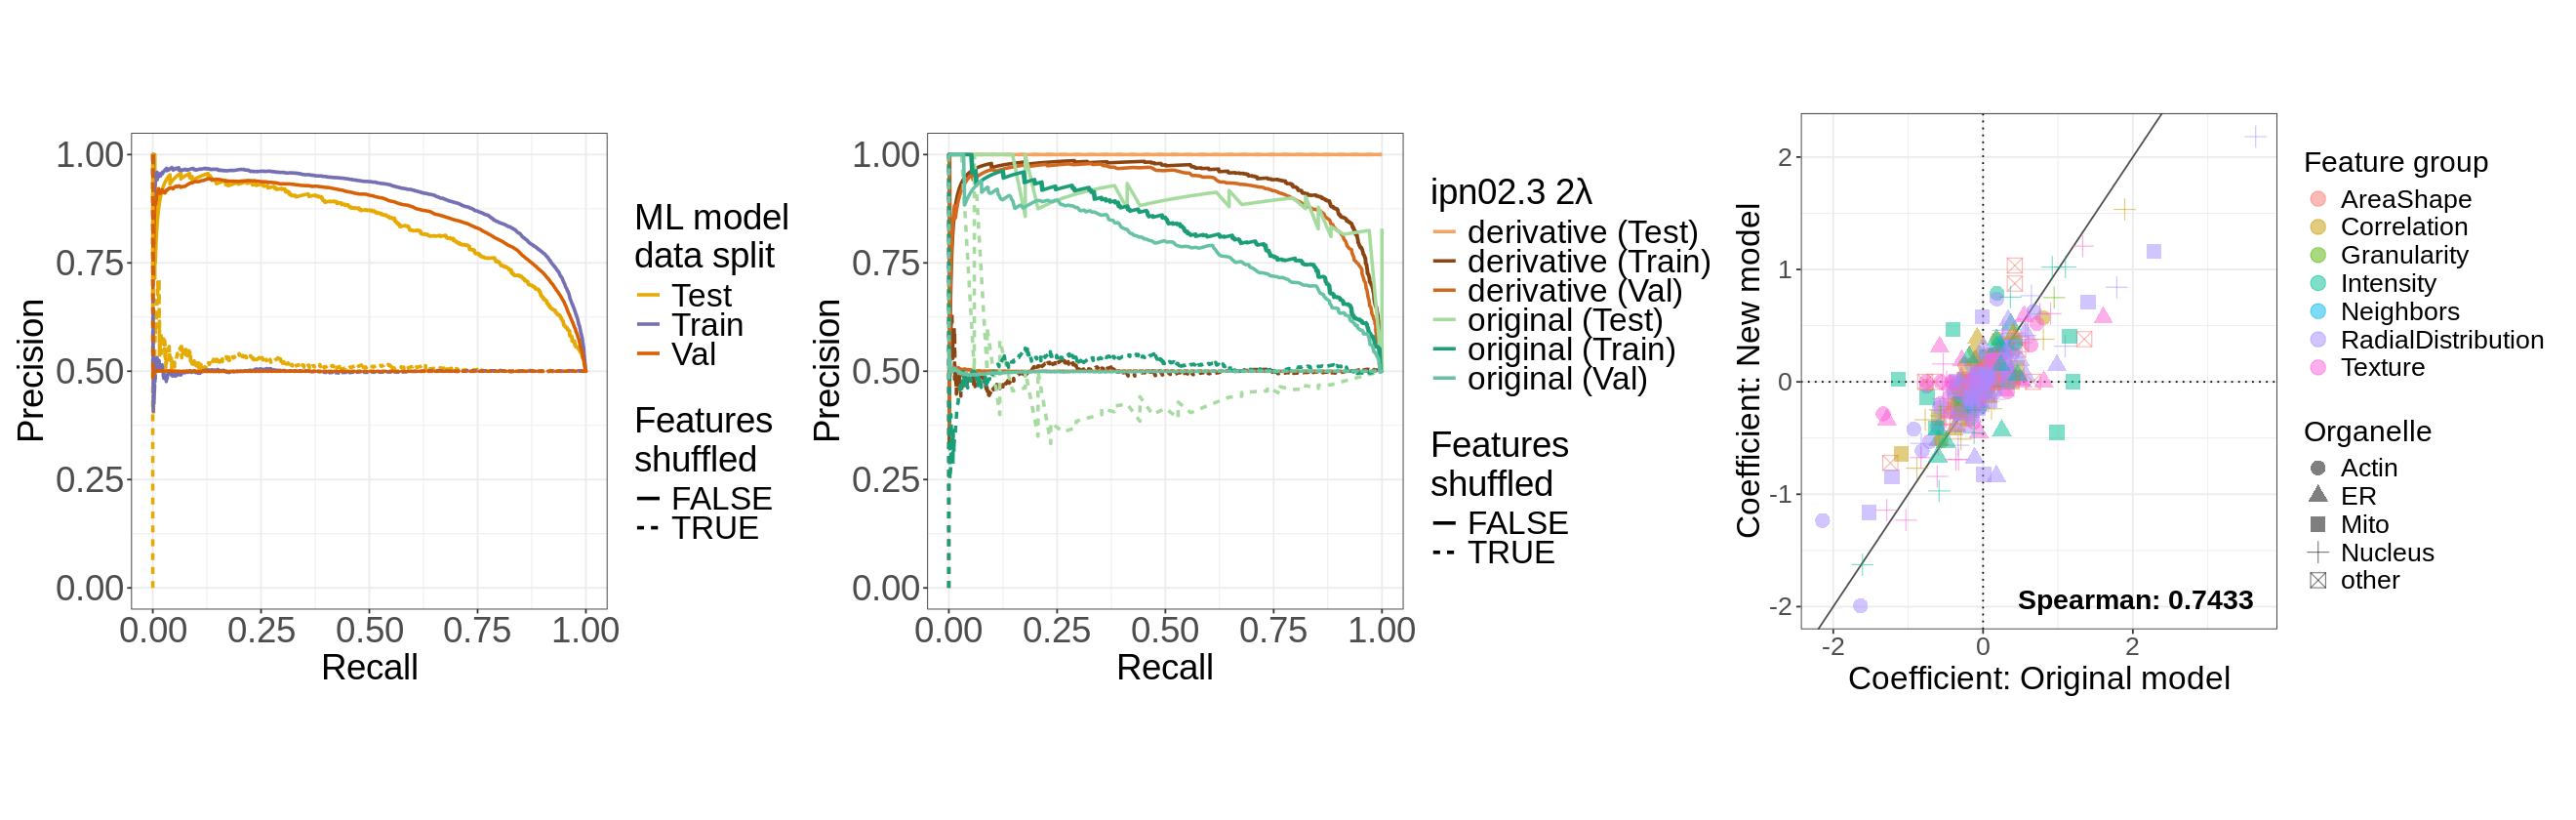

In [23]:
width <- 22
height <- 7
options(repr.plot.width = width, repr.plot.height = height)

bottom_plot <- (
    pr_new_model_all_plates_plot |
    pr_plate_6_deriv_plot |
    scatterplot_models
) + plot_layout(widths = c(2,2,2))

bottom_plot

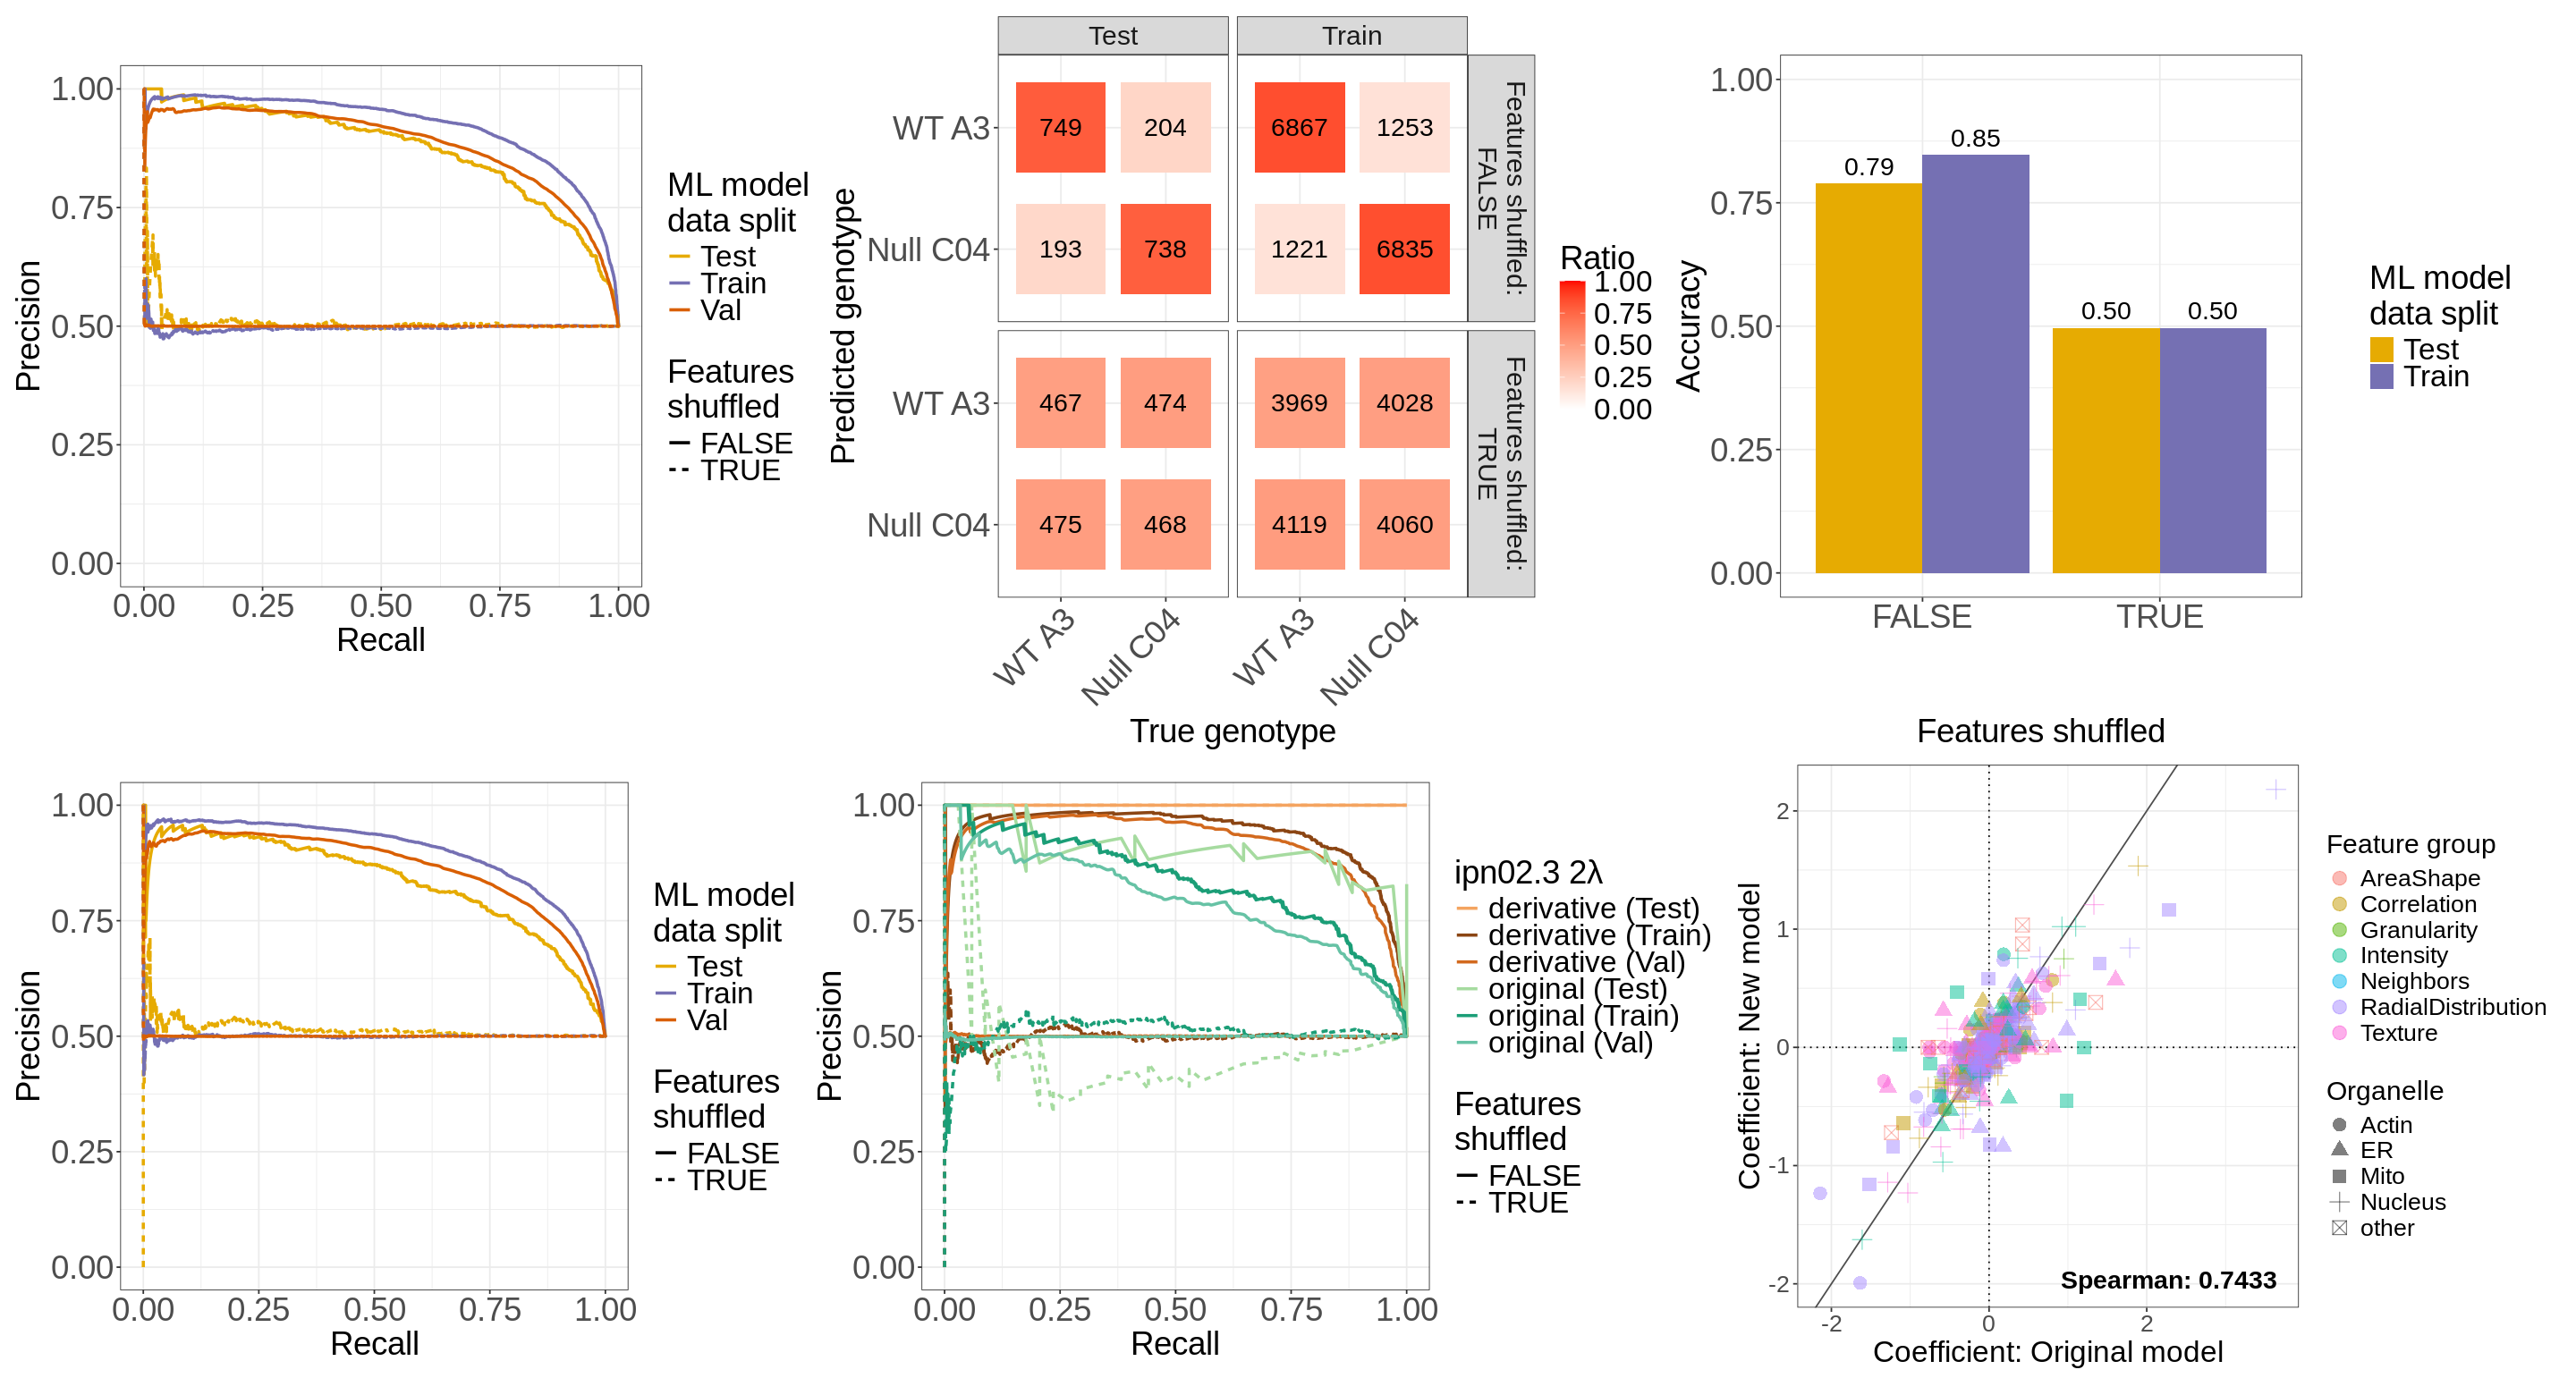

In [24]:
width <- 24
height <- 13
options(repr.plot.width = width, repr.plot.height = height)

align_plot <- top_plot / bottom_plot + plot_layout(heights = c(1, 1))

align_plot

In [25]:
fig_3_gg <- (
  align_plot
) + plot_annotation(tag_levels = list(c("A", "B", "C", "D", "E", "F"))) & theme(plot.tag = element_text(size = 25))

# Save the plot
ggsave(output_main_figure_3, plot = fig_3_gg, dpi = 500, height = height, width = width)